# Quality assessment of ASHES Vent Field 3D seafloor temperature measures.

## ASHES Vent Field

The ASHES Vent Field is a hydrothermal vent system found on the Juan de Fuca plate and monitored by the Cabled Axial Seamount array. 

![A map of the OOI's cabled arrays showing the location of the Axial Seamount off the Pacific Coast of the US on the western side of the Juan de Fuca plate](https://oceanobservatories.org/wp-content/uploads/2018/03/CEV-OOI-Cabled-Array-Axial-8.5w-300dpi.jpg)

Monitored by the westernmost node in the array, chemical and biological data at this active vent are measured by a number of sensors, including an HD video camera and a 3D thermistor array.

![A zoomed in view of the cabled array showing the different nodes at the seamount](https://oceanobservatories.org/wp-content/uploads/2015/10/PN3B_Cabled_Axial_Seamount.jpg)

## Evaluation of Diffuse Vent Fluid 3D Temperature Array
### Reference Designator RS03ASHS-MJ03B-07-TMPSFA301

The main purpose of this data quality report is to investigate the reliability of temperature readings from the unique Diffuse Vent Fluid 3D Temperature Array deployed on Mushroom Vent in the ASHES Vent Field. This instrument records temperature from 24 individual thermistors to measure the variability in vent fluid temperature over small time and spatial scales.

<img src="https://oceanobservatories.org/wp-content/uploads/2015/09/TMPSF_diagram-640x534.png" alt="3D diagram of the 24 thermistor array in several vertical triangular arrangements" height="150px"/> <img src="https://oceanobservatories.org/wp-content/uploads/2015/09/r1632_thermistor.deployed_med.jpg" alt="a photo of the thermistor array deployed near Mushroom Vent" height="150px"/>



These thermistors are placed on Mushroom Vent in a coordinate arrangement described in more detail in the instrument's [Data Product Specification (DPS) document](https://oceanobservatories.org/wp-content/uploads/2015/10/1341-00130_Data_Product_Spec_TEMPSFL_OOI.pdf). The first task in evaluating the quality of this instrument will be to determine if any of the 24 sensors are getting readings significantly different from the other thermistors. The array is constructed using an [RBRconcerto thermistor string](https://rbr-global.com/products/standard-loggers/thermistor-strings), and the specifications cite that the thermistors typically have a 0.002°C/year drift rate.

### Request metadata and annotations from the Diffuse Vent Fluid 3D Temperature Array

In [2]:
##Defining the Username and Token to be used with the OOI API
USERNAME = ''
TOKEN =  ''

In [3]:
##Importing the necessary Python modules
import requests
import datetime
import time
import xarray as xr
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.dates as dates

### Checking instrument metadata vocabulary

In [3]:
# Instrument Information
site = 'RS03ASHS'
node = 'MJ03B'
instrument = '07-TMPSFA301'

VOCAB_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
request_url ='/'.join((VOCAB_BASE_URL,site,node,instrument))

# Retrieve vocabulary information for a given instrument
r = requests.get(request_url, auth=(USERNAME, TOKEN))
data = r.json()   ##turn JSON array into a python array

##Print info to confirm I'm retrieving data from the correct source
print("%s, %s, %s" % (data[0]['tocL1'],data[0]['tocL2'],data[0]['instrument']))

Cabled Axial Seamount, ASHES Vent Field, Diffuse Vent Fluid 3-D Temperature Array


### Examining annotations for instrument data

In [4]:
# Specify a reference designator
refdes = 'RS03ASHS-MJ03B-07-TMPSFA301'

# Request all annotations since the instrument has been deployed
begin = int(datetime.date(2013,1,1).strftime('%s'))*1000
end = int(datetime.datetime.now().strftime("%s")) * 1000 # current date

ANNO_API = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'
params = {
  'beginDT': begin,
  'endDT': end,
  'refdes': refdes,
}

# Send the request
r = requests.get(ANNO_API, params=params, auth=(USERNAME, TOKEN))
data = r.json()

In [5]:
##Format the annotations and timestamps

# convert timestamps
def convert_time(ms):
    if ms != None:
        return datetime.datetime.utcfromtimestamp(ms/1000)
    else:
        return None
    
# Convert info the json response to a dataframe for easier visualization
df = pd.DataFrame() # Setup empty array
for d in data:
    df = df.append({
        'annotation_id': d['id'],
        'subsite': d['subsite'],
        'node': d['node'],
        'sensor': d['sensor'],
        'stream': d['stream'],
        'method': d['method'],
        'start': convert_time(d['beginDT']),
        'stop': convert_time(d['endDT']),
        'qcFlag': d['qcFlag'],
        'annotation': d['annotation']
    }, ignore_index=True)
pd.set_option('display.max_colwidth', -1) # Show the full annotation text
dfsorted = df.sort_values("start")  # Sort order of annotations by start date
dfsorted

,annotation,annotation_id,method,node,qcFlag,sensor,start,stop,stream,subsite
1,2014-09-29 19:03:12.000: Begin of data from deployment one. The instrument was deployed on 2014-09-28 at 02:21:00.000.,192.0,streamed,MJ03B,pass,07-TMPSFA301,2014-09-29 19:03:12,2014-09-29 19:03:12,tmpsf_sample,RS03ASHS
8,"Note: PFE down. HVPS1 MOV explosion, 800A breaker tripped, investigation and restoration",1067.0,None,None,None,None,2014-12-07 19:45:00,2014-12-16 00:00:00,None,RS03ASHS
9,Note: PNWGP Portland <-> Seattle outage,1074.0,None,None,None,None,2015-01-07 07:32:00,2015-01-07 08:06:00,None,RS03ASHS
10,Note: Intermittent partial data loss due to storage drive problems at OTB,1081.0,None,None,None,None,2015-01-31 00:00:00,2015-02-04 00:00:00,None,RS03ASHS
11,Note: PNWGP outage due to City of Seattle fiber cable work,1088.0,None,None,None,None,2015-03-21 14:10:00,2015-03-22 04:20:00,None,RS03ASHS
12,Note: Network issues due to fire that damaged fibers between Portland and Seattle,1095.0,None,None,None,None,2015-06-13 00:00:00,2015-06-15 16:30:00,None,RS03ASHS
5,Data gap. Unknown reason.,197.0,streamed,MJ03B,not_available,07-TMPSFA301,2015-06-30 08:43:00,2015-07-10 06:22:00,tmpsf_sample,RS03ASHS
3,Unexplained loss of power at Pittock Building in Portland.,194.0,streamed,MJ03B,not_available,07-TMPSFA301,2015-07-10 20:00:00,2015-07-13 12:00:00,tmpsf_sample,RS03ASHS
13,Note: Outage during major utility power failure in Seattle,1102.0,None,None,None,None,2015-08-29 00:00:00,2015-08-29 00:30:00,None,RS03ASHS
14,Note: Four 1-minute outages between Portland and Seattle due to maintenance,1109.0,None,None,None,None,2016-01-07 06:10:00,2016-01-07 06:52:00,None,RS03ASHS


From these annotations, we can see that the 3D array has previously had issues with individual thermistors reading incorrect values. In both cases, the thermistors read anomalously high temperatures.

In January of 2017, Thermistor 6 began reading significantly high temperatures, and in June of 2017 Thermistor 2 exhibited similar errant behavior.

In [ ]:
df.iloc[[0,6],[0,6,7]]

Since the dataset for this analysis will begin after August 2017, this will not impact the data report. Those two instances do, however, provide a useful case for testing the accuracy of tests for consistency among thermistors.

Only data collected between May 1st, 2018 and July 31st, 2018 will be analyzed for this report, and there are no annotations listed above that fall within that time period.

### Request sensor data from Diffuse Vent Fluid 3-D Temperature Array

In [6]:
# Instrument Information
site = 'RS03ASHS'
node = 'MJ03B'
instrument = '07-TMPSFA301'
method = 'streamed'
stream = 'tmpsf_sample'

# API base url
SENSOR_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

# Create the full request URL
data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))

# All of the following are optional
params = {
  'beginDT':'2018-05-01T01:01:01.000Z',
  'endDT':'2018-07-31T01:00:00.000Z',
  'format':'application/netcdf',
  'include_provenance':'true',
  'include_annotations':'true'
}


Actually request the data! **RUN ONLY ONCE**

In [ ]:
#r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
#data = r.json()
#print(data['allURLs'][0])

The following are the four THREDDS OPeNDAP URLs corresponding to the four 3-month datasets.

In [4]:
url = "https://opendap.oceanobservatories.org/thredds/catalog/ooi/alanna.g.durkin@gmail.com/20180806T213525-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/catalog.html"

The following code to makes sure all data files requested are finalized.

In [ ]:
# import time
%time
check_complete = data['allURLs'][1] + '/status.txt'
for i in range(1800):
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
            time.sleep(1)

In [5]:
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'

datasets = requests.get(url).text
##Find the URL for the NetCDF file out of the other links listed on the catalog page
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/alanna.g.durkin@gmail.com/20180806T213525-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0003_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20180501T010103.424119-20180731T005950.317757.nc']

In [6]:
##Load the data files
ds = xr.open_mfdataset(datasets)
# By default, OOI datasets use the 'obs' variable as the index, but time is more convenient
ds = ds.swap_dims({'obs': 'time'}) 
# Sort the data
ds = ds.sortby('time'); 
# Optional, this is used to optimize data processing
ds = ds.chunk({'time': 100}) 
ds

<xarray.Dataset>
Dimensions:                    (time: 776389)
Coordinates:
    obs                        (time) int32 dask.array<shape=(776389,), chunksize=(100,)>
  * time                       (time) datetime64[ns] 2018-05-01T01:01:03.424118784 ...
    lat                        (time) float64 dask.array<shape=(776389,), chunksize=(100,)>
    lon                        (time) float64 dask.array<shape=(776389,), chunksize=(100,)>
Data variables:
    deployment                 (time) int32 dask.array<shape=(776389,), chunksize=(100,)>
    id                         (time) |S64 dask.array<shape=(776389,), chunksize=(100,)>
    battery_voltage            (time) float32 dask.array<shape=(776389,), chunksize=(100,)>
    driver_timestamp           (time) datetime64[ns] dask.array<shape=(776389,), chunksize=(100,)>
    ingestion_timestamp        (time) datetime64[ns] dask.array<shape=(776389,), chunksize=(100,)>
    internal_timestamp         (time) datetime64[ns] dask.array<shape=(776389,

In [7]:
#Create list of QC variables to drop from the dataset
QC_vars = []
temp_vars = []
for i in range(1,25):
    if i < 10:
        QC_vars.append("temperature0"+str(i)+"_qc_executed")
        QC_vars.append("temperature0"+str(i)+"_qc_results")
        temp_vars.append("temperature0"+str(i))
    else:
        QC_vars.append("temperature"+str(i)+"_qc_executed")
        QC_vars.append("temperature"+str(i)+"_qc_results")
        temp_vars.append("temperature"+str(i))

#Drop QC variables from the dataset
temp_only_ds = ds.drop(QC_vars)
temp_only_ds

<xarray.Dataset>
Dimensions:              (time: 776389)
Coordinates:
    obs                  (time) int32 dask.array<shape=(776389,), chunksize=(100,)>
  * time                 (time) datetime64[ns] 2018-05-01T01:01:03.424118784 ...
    lat                  (time) float64 dask.array<shape=(776389,), chunksize=(100,)>
    lon                  (time) float64 dask.array<shape=(776389,), chunksize=(100,)>
Data variables:
    deployment           (time) int32 dask.array<shape=(776389,), chunksize=(100,)>
    id                   (time) |S64 dask.array<shape=(776389,), chunksize=(100,)>
    battery_voltage      (time) float32 dask.array<shape=(776389,), chunksize=(100,)>
    driver_timestamp     (time) datetime64[ns] dask.array<shape=(776389,), chunksize=(100,)>
    ingestion_timestamp  (time) datetime64[ns] dask.array<shape=(776389,), chunksize=(100,)>
    internal_timestamp   (time) datetime64[ns] dask.array<shape=(776389,), chunksize=(100,)>
    port_timestamp       (time) datetime64[ns

In [8]:
#Convert the dataset to a pandas dataframe
temp_df = temp_only_ds.to_dataframe()

In [9]:
#Resample a new dataframe made up of just the hourly minimum values for each sensor
min_temp_df = temp_df.resample("H").min()
#Resample to create another new dataframe of hourly max temp values
max_temp_df = temp_df.resample("H").max()
#Resample again for average values
mean_temp_df = temp_df.resample("H").mean()

In [10]:
#Find the minimum of all 24 sensor readings for each hour and create a new column in the dataframe for min data
min_temp_df["min_of_all_sensors"] = min_temp_df[temp_vars].min(axis=1)
#Record the mean of all 24 sensor readings for each hour
mean_temp_df["mean_of_all_sensors"] = mean_temp_df[temp_vars].mean(axis=1)
#Record the max of all 24 sensor readings for each hour
max_temp_df["max_of_all_sensors"] = max_temp_df[temp_vars].max(axis=1)

mean_temp_df.head()

,obs,deployment,battery_voltage,temperature01,temperature02,temperature03,temperature04,temperature05,temperature06,temperature07,...,temperature18,temperature19,temperature20,temperature21,temperature22,temperature23,temperature24,lat,lon,mean_of_all_sensors
time,,,,,,,,,,,,,,,,,,,,,
2018-05-01 01:00:00,176.5,3.0,12.001537,4.320561,2.615127,3.247355,3.316934,4.218474,2.686641,5.662786,...,3.050398,3.295059,2.612998,2.863696,2.847985,2.559917,2.588942,45.93362,-130.01368,3.370301
2018-05-01 02:00:00,533.5,3.0,12.002085,4.067965,2.603067,3.485968,3.476108,3.421320,2.649455,4.593305,...,3.318207,3.131854,2.532021,2.749180,2.956615,2.517628,2.576412,45.93362,-130.01368,3.307718
2018-05-01 03:00:00,893.5,3.0,12.001476,4.233697,2.580752,3.074167,3.436037,3.716433,2.687001,5.658590,...,3.125487,3.399920,2.612876,2.895756,2.975425,2.589688,2.585143,45.93362,-130.01368,3.396128
2018-05-01 04:00:00,1253.5,3.0,12.002571,5.889357,2.542058,2.728314,2.839660,4.892677,2.980346,7.685214,...,2.754331,3.591207,3.474447,2.977616,2.699703,2.876985,2.577370,45.93362,-130.01368,3.521051
2018-05-01 05:00:00,1613.5,3.0,12.001964,4.767014,2.567992,2.651522,2.571408,3.220058,3.102270,8.642864,...,2.519681,2.507253,2.561828,2.709125,2.490590,2.479819,2.481922,45.93362,-130.01368,3.068912


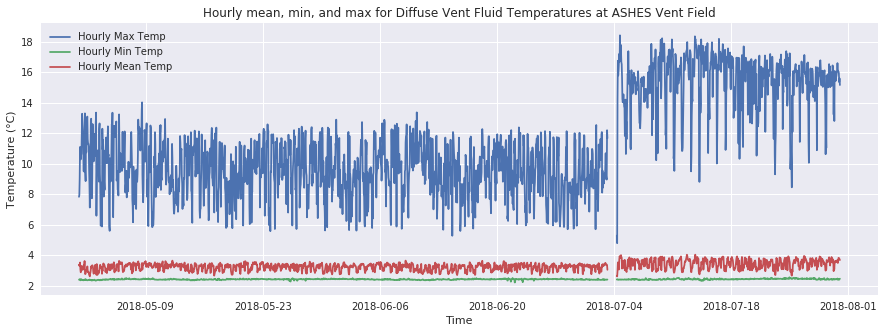

In [14]:
#Plot hourly min, max, and mean over entire time series to see spread
sns.set()
plt.figure(figsize=(15,5))
plt.plot(max_temp_df["max_of_all_sensors"])
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.plot(min_temp_df["min_of_all_sensors"])
plt.plot(mean_temp_df["mean_of_all_sensors"])
plt.title("Hourly mean, min, and max for Diffuse Vent Fluid Temperatures at ASHES Vent Field")
plt.legend(("Hourly Max Temp","Hourly Min Temp","Hourly Mean Temp"))

The above plot shows the range of temperatures measured by the 24 thermistors. The minimum values are steady at just above 2°C, which approximately the seawater temperature that would be expected at the 1500m depth location for this sensor. The maximum readings show that temperatures range over 10°C among the thermistors in the array, which is within a reasonable range for this diffuse vent site$.^{1,2}$

There is a slightly disconcerting jump in the data, however, around July 4th, 2018. Although it is not noted in the annotations, this is due to a redeployment of the instrument during a maintenance cruise to the Cabled Array (Sage Lichtenwalner, pers. comm.). The minimum readings remain steady between the deployment periods, but the mean and maximum temperatures among the thermistors center around higher temperatures after July 4th. The most likely explanation is that the array is recording max temperatures more than 5°C higher than before because the instrument was redeployed closer to a vent plume. Until this location adjustment is confirmed by cruise participants and noted in the annotations though, it is possible that a re-calibration or other sensor issues are at fault for the discrepancy in readings.

### Comparing recent data temperature range to periods of known sensor issues

To investigate the possibility that these higher maximum temperature readings are the result of a single faulty sensor, the recent three-month period of data from the 3D thermistor array will be compared to three-month-long periods where there was a known issues with an individual sensor as described in the annotations. In both of these instances, a single thermistor recorded erroneously _high_ temperatures.

Since both Thermistor 6 and Thermistor 2 were reporting anomalously high temperatures between June and August in 2017, the signal from Thermistor 2's failure would most likely be masked by Thermistor 6's high temperature data in the analysis for this report. Only the three-month-long period surrounding Thermistor 6's initial failure in January 2017 will be examined here for illustrative purposes.

In [15]:
# Instrument Information
site = 'RS03ASHS'
node = 'MJ03B'
instrument = '07-TMPSFA301'
method = 'streamed'
stream = 'tmpsf_sample'

# API base url
SENSOR_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

# Create the full request URL
data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))

# All of the following are optional
params = {
  'beginDT':'2016-12-01T01:01:01.000Z',
  'endDT':'2017-02-28T01:00:00.000Z',
  'format':'application/netcdf',
  'include_provenance':'true',
  'include_annotations':'true'
}

In [ ]:
#r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
#data = r.json()
#print(data['allURLs'][0])

In [10]:
bad_temp_url = "https://opendap.oceanobservatories.org/thredds/catalog/ooi/alanna.g.durkin@gmail.com/20180809T183420-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/catalog.html"

In [11]:
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
bad_temp_datasets = requests.get(bad_temp_url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', bad_temp_datasets)
x = re.findall(r'(ooi/.*?.nc)', bad_temp_datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
bad_temp_datasets = [os.path.join(tds_url, i) for i in x]
bad_temp_datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/alanna.g.durkin@gmail.com/20180809T183420-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0001_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20161201T010111.110698-20170228T005955.127255.nc']

In [19]:
bad_temp_ds = xr.open_mfdataset(bad_temp_datasets)
bad_temp_ds = bad_temp_ds.swap_dims({'obs': 'time'}) 
bad_temp_ds = bad_temp_ds.sortby('time'); 
bad_temp_ds = bad_temp_ds.chunk({'time': 100}) 

#Drop QC variables from the dataset
bad_temp_only_ds = bad_temp_ds.drop(QC_vars)
#Convert the dataset to a pandas dataframe
bad_temp_df = bad_temp_only_ds.to_dataframe()

In [20]:
#Resample a new dataframe made up of just the hourly minimum values for each sensor
bad_min_temp_df = bad_temp_df.resample("H").min()
#Resample to create another new dataframe of hourly max temp values
bad_max_temp_df = bad_temp_df.resample("H").max()
#Resample again for average values
bad_mean_temp_df = bad_temp_df.resample("H").mean()

#Find the min, max, and average of all the hourly mins, maxes, and averages
bad_max_temp_df["max_of_all_sensors"] = bad_max_temp_df[temp_vars].max(axis=1)  #find max of each row looking only at temperature sensor columns
bad_min_temp_df["min_of_all_sensors"] = bad_min_temp_df[temp_vars].min(axis=1)
bad_mean_temp_df["mean_of_all_sensors"] = bad_mean_temp_df[temp_vars].mean(axis=1)

bad_max_temp_df.head()

,obs,deployment,id,battery_voltage,driver_timestamp,ingestion_timestamp,internal_timestamp,port_timestamp,preferred_timestamp,provenance,...,temperature19,temperature20,temperature21,temperature22,temperature23,temperature24,timestamp,lat,lon,max_of_all_sensors
time,,,,,,,,,,,,,,,,,,,,,
2016-12-01 01:00:00,294.0,1.0,b'ff2838cf-6c6a-4597-9d9a-8d85f2cccfe3',12.0003,2016-12-01 01:59:59.390722048,2016-12-01 02:00:03.034999808,2016-12-01 02:00:00,2016-12-01 01:59:59.111528960,b'port_timestamp',b'a98e9d48-9169-466f-a697-79ee3e5a22c1',...,2.6353,2.6319,2.8779,2.5021,2.6189,3.5472,b'3.6895464E9',45.93362,-130.01368,7.8942
2016-12-01 02:00:00,594.0,1.0,b'fa2116f6-f238-456f-ad97-b833c952af6c',11.9857,2016-12-01 02:59:59.416268288,2016-12-01 03:00:03.698999808,2016-12-01 03:00:00,2016-12-01 02:59:59.108955648,b'port_timestamp',b'a98e9d48-9169-466f-a697-79ee3e5a22c1',...,2.5968,2.6167,2.9452,2.5162,2.5837,3.4473,b'3.68955E9',45.93362,-130.01368,7.2409
2016-12-01 03:00:00,894.0,1.0,b'ffe9359a-ad93-4aff-a9e1-fed2ab158e84',12.0003,2016-12-01 03:59:59.333316608,2016-12-01 03:59:59.816000000,2016-12-01 04:00:00,2016-12-01 03:59:59.107923968,b'port_timestamp',b'a98e9d48-9169-466f-a697-79ee3e5a22c1',...,2.6696,2.7642,3.1926,2.5992,2.5789,3.3433,b'3.689553E9',45.93362,-130.01368,6.6771
2016-12-01 04:00:00,1194.0,1.0,b'ff80e7ea-4033-48f4-a01a-a4db5b6cd4c1',11.9857,2016-12-01 04:59:59.368076288,2016-12-01 05:00:00.050000384,2016-12-01 05:00:00,2016-12-01 04:59:59.107612672,b'port_timestamp',b'a98e9d48-9169-466f-a697-79ee3e5a22c1',...,2.6295,2.7293,3.1100,2.5953,2.6071,3.2678,b'3.6895572E9',45.93362,-130.01368,7.3394
2016-12-01 05:00:00,1494.0,1.0,b'ff443691-3782-4b87-bc16-97d6643d3040',11.9857,2016-12-01 05:59:59.364997120,2016-12-01 06:00:00.902000128,2016-12-01 06:00:00,2016-12-01 05:59:59.106252800,b'port_timestamp',b'a98e9d48-9169-466f-a697-79ee3e5a22c1',...,2.6339,2.7292,3.1455,2.5682,2.5959,3.7821,b'3.6895608E9',45.93362,-130.01368,7.1301


(0, 105)

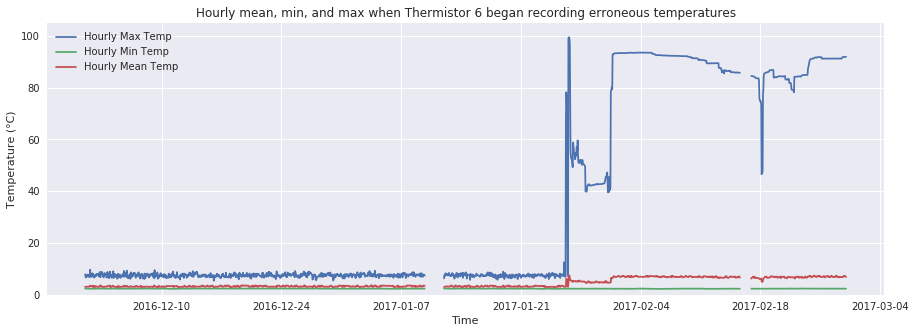

In [20]:
#Plot hourly min, max, and mean over entire time series to see spread
sns.set()

##plot of bad data before and after thermistor 6 started acting up

plt.subplots(figsize=(15,5))
plt.plot(bad_max_temp_df["max_of_all_sensors"])
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.plot(bad_min_temp_df["min_of_all_sensors"])
plt.plot(bad_mean_temp_df["mean_of_all_sensors"])
plt.title("Hourly mean, min, and max when Thermistor 6 began recording erroneous temperatures")
plt.legend(("Hourly Max Temp","Hourly Min Temp","Hourly Mean Temp"))
plt.ylim(0,105)

It's clear that Thermistor 6 brought the maximum temperature far out of the expected range for this vent. When the most recent thermistor array data is plotted as before but with the same y-axis ranges as the bad temperature time-period, the new values since the July 4th period are still noticeable but not quite so alarming.

(0, 105)

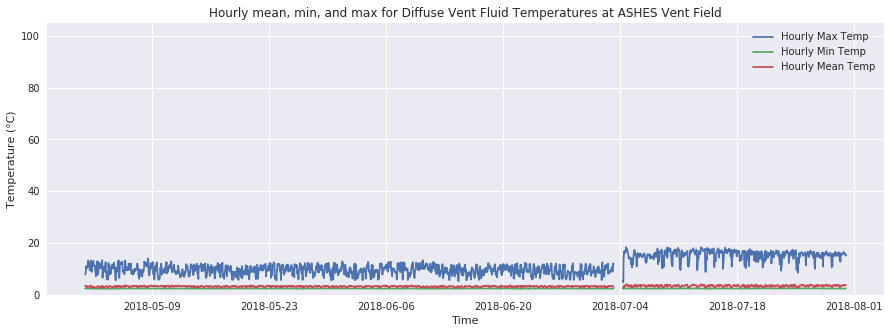

In [21]:
#Plot most recent temperature data and bad temperature data for a side-by-side (well, vertical) comparison

##plot of recent data 
plt.subplots(figsize=(15,5))
plt.plot(max_temp_df["max_of_all_sensors"])
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.plot(min_temp_df["min_of_all_sensors"])
plt.plot(mean_temp_df["mean_of_all_sensors"])
plt.title("Hourly mean, min, and max for Diffuse Vent Fluid Temperatures at ASHES Vent Field")
plt.legend(("Hourly Max Temp","Hourly Min Temp","Hourly Mean Temp"))
plt.ylim(0,105)

### Calculating streak counts for individual thermistors recording maximum temperatures

Another method for analyzing the reliability of individual thermistors within the array is to see how frequently different sensors are measuring the maximum temperature. If one sensor out of 24 is nearly always detecting the highest temperature, this is an indicator that that thermistor may have an issue.

After locating the sensor responsible for the maximum temperature during each hour and counting the number of hours it remains the maximum sensor, the count will represent how many continuous timepoints that particular sensor measured a higher temperature than the other 23 thermistors in the array. If the maximum temperature sensor changes almost every hour, streaks will be centered around a mean of 1. Outliers with significantly higher frequencies visualized in a histogram will indicate particular sensors that may be reading erroneously high temperatures.

In [22]:
#Find the sensor that recorded the maximum temperature for each row (each hourly timepoint)
maxIDs = max_temp_df[temp_vars].idxmax(axis=1)

#Create a list to store the number of consecutive hours that the same sensor recorded the maximum temperature in the array
max_streaks = []
#Create a corresponding list to store which sensors had the longest streaks if they prove to be outliers
max_sensors = []

#Populate that list by looping through the maxIDs dataframe and noting how many rows until the sensor name changes
streak_count = 1
max_sensor_name = maxIDs[0]
for i in range(1,len(maxIDs)):
    if maxIDs[i] == max_sensor_name:
        streak_count += 1
    else:
        max_sensor_name = maxIDs[i]
        max_streaks.append(streak_count)
        max_sensors.append(max_sensor_name)
        streak_count = 1        
max_streaks.append(streak_count)
max_sensors.append(max_sensor_name)

#Create a pandas dataframe from the lists
streak_data = pd.DataFrame({"StreakCount":max_streaks,"SensorName":max_sensors})
#Sort dataframe in descending order to show the longest streaks and potential outliers first
streak_data = streak_data.sort_values("StreakCount",axis=0,ascending=False)
streak_data.head()

,StreakCount,SensorName
503,639,temperature07
1,35,temperature08
377,18,temperature08
18,17,temperature08
36,16,temperature08


To visualize the distribution of streaks among sensors, I'll plot a histogram of the streak data to see if any outliers are measuring the maximum temperature for unexpectedly long periods of time.

Text(0,0.5,'Frequency')

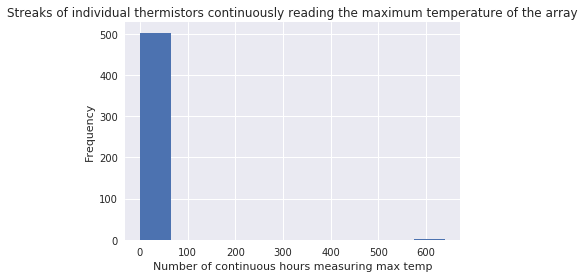

In [23]:
plt.hist(max_streaks)
plt.title("Streaks of individual thermistors continuously reading the maximum temperature of the array")
plt.xlabel("Number of continuous hours measuring max temp")
plt.ylabel("Frequency")

The histogram of frequencies has revealed a huge outlier with Thermistor 7's max streak of 639 hours. From previous analysis for a workshop plotting exercise, it is known that this streak corresponds to the latest data from the thermistor array. Also, 639 hours is equal to the length of time the instrument was recording from the redeployment on July 4th to the end date for the dataset of July 31st. This suggests that Thermistor 7 has been the only sensor reading the maximum temperature since the instrument was redeployed.

Text(0,0.5,'Frequency')

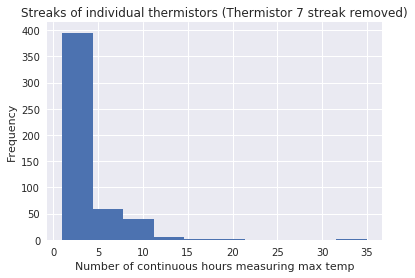

In [24]:
max_streaks.remove(639)
plt.hist(max_streaks)
plt.title("Streaks of individual thermistors (Thermistor 7 streak removed)")
plt.xlabel("Number of continuous hours measuring max temp")
plt.ylabel("Frequency")

After the long Thermistor 7 streak is removed, the greatest frequencies in the histogram are less than 5 hours, suggesting that the sensor reading the maximum temperature changes almost every hour. Only one value is greater than 24 hours, so only rarely does a sensor read the maximum temperature of the array continously for a full day.

To confirm that this is a problematic streak, the same analysis can also be applied to the period of time when Thermistor 6 was known to be reading too high.

In [25]:
#Find the sensor that recorded the maximum temperature for each row (each hourly timepoint)
bad_maxIDs = bad_max_temp_df[temp_vars].idxmax(axis=1)

#Create a list to store the number of consecutive hours that the same sensor recorded the maximum temperature in the array
bad_max_streaks = []
#Create a corresponding list to store which sensors had the longest streaks if they prove to be outliers
bad_max_sensors = []

#Populate that list by looping through the maxIDs dataframe and noting how many rows until the sensor name changes
bad_streak_count = 1
bad_max_sensor_name = bad_maxIDs[0]
for i in range(1,len(bad_maxIDs)):
    if bad_maxIDs[i] == bad_max_sensor_name:
        bad_streak_count += 1
    else:
        bad_max_sensor_name = bad_maxIDs[i]
        bad_max_streaks.append(bad_streak_count)
        bad_max_sensors.append(bad_max_sensor_name)
        bad_streak_count = 1        
bad_max_streaks.append(bad_streak_count)
bad_max_sensors.append(bad_max_sensor_name)

#Create a pandas dataframe from the lists
bad_streak_data = pd.DataFrame({"StreakCount":bad_max_streaks,"SensorName":bad_max_sensors})
#Sort dataframe in descending order to show the longest streaks and potential outliers first
bad_streak_data = bad_streak_data.sort_values("StreakCount",axis=0,ascending=False)
bad_streak_data.head()

,StreakCount,SensorName
412,482,NaN
444,267,temperature06
396,35,temperature01
147,27,temperature01
52,23,temperature01


As evidenced by the gaps in the data in the plot from December 2016 through February 2017, there are 84 NaNs remaining in the max values of the thermistor readings that must be removed before calculating the streaks.

In [26]:
sum(np.isnan(bad_max_temp_df["max_of_all_sensors"]))

84

In [27]:
len(bad_max_temp_df["max_of_all_sensors"])

2136

In [28]:
bad_max_temp_df = bad_max_temp_df.dropna()
len(bad_max_temp_df["max_of_all_sensors"])

2052

In [29]:
#Find the sensor that recorded the maximum temperature for each row (each hourly timepoint)
bad_maxIDs = bad_max_temp_df[temp_vars].idxmax(axis=1)

#Create a list to store the number of consecutive hours that the same sensor recorded the maximum temperature in the array
bad_max_streaks = []
#Create a corresponding list to store which sensors had the longest streaks if they prove to be outliers
bad_max_sensors = []

#Populate that list by looping through the maxIDs dataframe and noting how many rows until the sensor name changes
bad_streak_count = 1
bad_max_sensor_name = bad_maxIDs[0]
for i in range(1,len(bad_maxIDs)):
    if bad_maxIDs[i] == bad_max_sensor_name:
        bad_streak_count += 1
    else:
        bad_max_sensor_name = bad_maxIDs[i]
        bad_max_streaks.append(bad_streak_count)
        bad_max_sensors.append(bad_max_sensor_name)
        bad_streak_count = 1        
bad_max_streaks.append(bad_streak_count)
bad_max_sensors.append(bad_max_sensor_name)

#Create a pandas dataframe from the lists
bad_streak_data = pd.DataFrame({"StreakCount":bad_max_streaks,"SensorName":bad_max_sensors})
#Sort dataframe in descending order to show the longest streaks and potential outliers first
bad_streak_data = bad_streak_data.sort_values("StreakCount",axis=0,ascending=False)
bad_streak_data.head()

,StreakCount,SensorName
359,749,temperature06
343,35,temperature01
147,27,temperature01
52,23,temperature01
252,21,temperature12


Now that the NaNs have been removed, the streak numbers are more accurate and Thermistor 6 is clearly identified as an outlier!

Text(0,0.5,'Frequency')

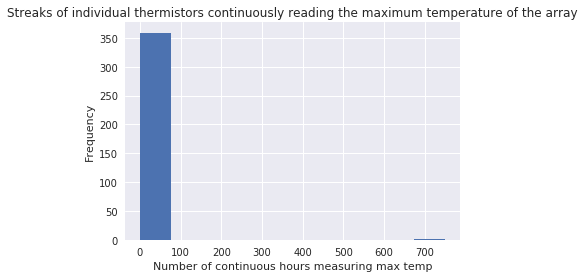

In [30]:
plt.hist(bad_max_streaks)
plt.title("Streaks of individual thermistors continuously reading the maximum temperature of the array")
plt.xlabel("Number of continuous hours measuring max temp")
plt.ylabel("Frequency")

To examine the non-outlier part of the distribution and compare it to the 2018 data, the erroneous maximum streak from Thermistor 6 will be removed and the two time periods plotted side by side.

Text(0.5,0,'Continuous hours at max temp')

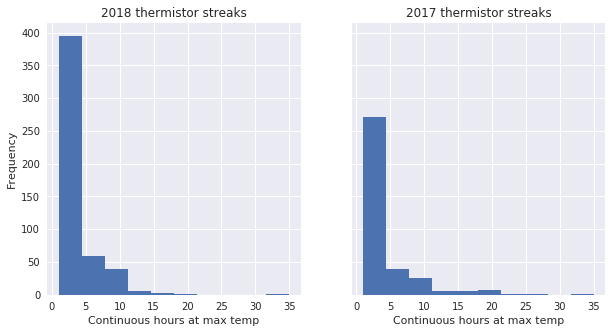

In [31]:
##Remove Thermistor 6 streak from dataset
bad_max_streaks.remove(749)

##Create a figure to hold two side-by-side subplots that will share a y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))

##Plot streaks from recent May-July 2018 data
ax1.hist(max_streaks)
ax1.set_title("2018 thermistor streaks")
ax1.set_xlabel("Continuous hours at max temp")
ax1.set_ylabel("Frequency")

##Plot streaks from December-February 2017 data
ax2.hist(bad_max_streaks)
ax2.set_title("2017 thermistor streaks")
ax2.set_xlabel("Continuous hours at max temp")


Both time periods produce a similar histogram with the vast majority of streaks below 5 hours long. The maximum non-outlier streak for both is 35 hours, with almost all other thermistors reading the maximum temperature for less than 24 hours in a row. The 0-5 hour bin has a higher frequency in the 2017 data because Thermistor 7 started reading continuously high later in that dataset than Thermistor 6 did within its three-month time period.

### Temperature difference between maximum temperature sensors and next highest temperature

Having discovered that Thermistor 7 has been reading the maximum temperature in the array since redeployment on July 4th, it is worth investigating what the difference is between Thermistor 7 and the next highest temperature reading across the three-month timeseries. How far is this maximum reading from the values recorded by the rest of the array?

The following time series plots are made using the full-resolution dataset, not the re-sampled hourly means.

In [32]:
#Save Thermistor 7 readings as a series
thermistor7 = temp_df["temperature07"]
#Drop Thermistor 7 from the columns to be analyzed for maximum
temp_vars.remove("temperature07")
#Recalculate the maximum temperature for each row
nonoutlier_max_temps = temp_df[temp_vars].max(axis=1)  #find max of each row looking only at temperature sensor columns

In [33]:
#Subtract the max temp from Thermistor 7's values
diff = thermistor7.subtract(nonoutlier_max_temps)

Text(0.5,1,'Difference between Thermistor 7 and the next highest temperature reading')

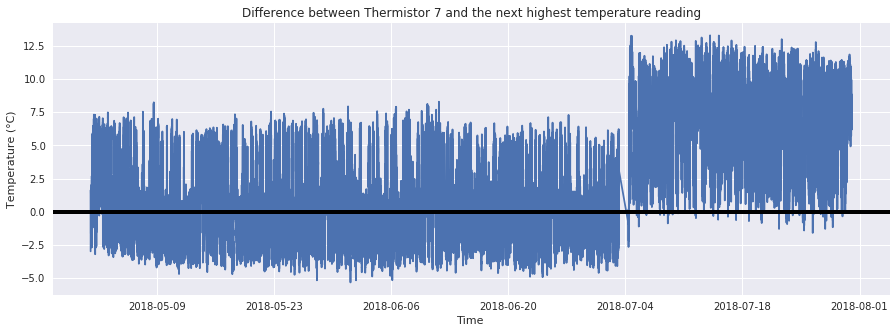

In [34]:
##plot of recent data 
plt.subplots(figsize=(15,5))
plt.plot(diff)
plt.axhline(linewidth=4,color="k")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("Difference between Thermistor 7 and the next highest temperature reading")


Although the high resolution dataset shows that there have been a handful of instances where Thermistor 7 was _not_ the maximum temperature after the July 4th redeployment, the individual sensor has ranged from 0°C to 12.5°C hotter than the next highest temperature thermistor in the array. This high of a temperature difference is unlikely to occur between two sensors that are only a few centimeters apart, but it might not be impossible. Where is Thermistor 7 located within the array? Could it be in the direct path of a vent plume that could cause this temperature differential between it and the rest of the sensors?

The XYZ coordinates of each sensor are listed in the [instrument's DPS document](https://oceanobservatories.org/wp-content/uploads/2015/10/1341-00130_Data_Product_Spec_TEMPSFL_OOI.pdf) and have been manually entered into the dictionary below.

In [35]:
from mpl_toolkits import mplot3d

IDs = range(1,25)
dict3D = {"X":[14.7,0,22,44,22,0,0,0,0,0,22,44,22,0,14.7,0,22,44,22,0,0,0,44,0],
          "Y":[25.4,0,12.7,25.4,38.1,50.8,25.4,25.4,25.4,50.8,38.1,25.4,12.7,0,25.4,0,12.7,25.4,38.1,50.8,25.4,50.8,25.4,0],
          "Z":[5.1,5.1,5.1,5.1,5.1,5.1,5.1,17.8,17.8,17.8,17.8,17.8,17.8,17.8,43.2,43.2,43.2,43.2,43.2,43.2,43.2,81.3,81.3,81.3],
         "ThermistorID":IDs}

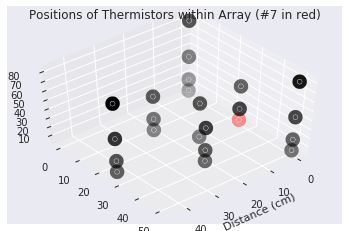

In [36]:
colors = ["k"]*24
colors[6] = "r"

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(dict3D["X"], dict3D["Y"], dict3D["Z"], c=colors,linewidth=10)
ax.set_xlabel("Distance (cm)")
ax.set_title("Positions of Thermistors within Array (#7 in red)")
ax.view_init(50, 50)

According to these coordinates, Thermistor 7 should be on the bottom of the array in the middle of one of the triangle's 3 sides. This _could_ potentially place Thermistor 7 closer to direct hydrothermal output than the rest of the array if that side of the triangle is sitting on top of an active plume. However, until exact placement is confirmed by deployment cruise notes or photos, the readings from Thermistor should still be treated as suspect.

## Temperature comparison the ASHES Vent Field CTD data
### Reference Designator RS03ASHS-MJ03B-10-CTDPFB304

The ASHES Vent Field has a co-located CTD to further investigate the accuracy of the temperature measurements from the 3D thermistor array.

**NOTES ON ACCESS TO CTD DATA:**
1. This CTD is not listed as being connected to the ASHES Vent Field node on the main OOI website. It is a PI-provided instrument instead of an OOI-provided instrument, but all of its data is still freely available to use.

2. If viewing plots from this data in the OOI Data Portal, the temperature and salinity data incorrectly appear as flatlines when the entire deployment time period is selected for the plot. Data must be requested from a shorter time period in order to observe the true measurements.

### Check vocabulary metadata

In [38]:
# Instrument Information
site = 'RS03ASHS'
node = 'MJ03B'
instrument = '10-CTDPFB304'

VOCAB_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
request_url ='/'.join((VOCAB_BASE_URL,site,node,instrument))

# Retrieve vocabulary information for a given instrument
r = requests.get(request_url, auth=(USERNAME, TOKEN))
data = r.json()   ##turn JSON array into a python array

##Print info to confirm I'm retrieving data from the correct source
print("%s, %s, %s" % (data[0]['tocL1'],data[0]['tocL2'],data[0]['instrument']))

Cabled Axial Seamount, ASHES Vent Field, CTD


### Check annotations for instrument

In [39]:
# Specify a reference designator
refdes = 'RS03ASHS-MJ03B-10-CTDPFB304'

# Request all annotations since the instrument has been deployed
begin = int(datetime.date(2017,8,1).strftime('%s'))*1000
end = int(datetime.datetime.now().strftime("%s")) * 1000 # current date

ANNO_API = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'
params = {
  'beginDT': begin,
  'endDT': end,
  'refdes': refdes,
}

# Send the request
r = requests.get(ANNO_API, params=params, auth=(USERNAME, TOKEN))
data = r.json()

In [40]:
##Format the annotations and timestamps

# convert timestamps
def convert_time(ms):
    if ms != None:
        return datetime.datetime.utcfromtimestamp(ms/1000)
    else:
        return None
    
# Convert info the json response to a dataframe for easier visualization
df = pd.DataFrame() # Setup empty array
for d in data:
    df = df.append({
        'annotation_id': d['id'],
        'subsite': d['subsite'],
        'node': d['node'],
        'sensor': d['sensor'],
        'stream': d['stream'],
        'method': d['method'],
        'start': convert_time(d['beginDT']),
        'stop': convert_time(d['endDT']),
        'qcFlag': d['qcFlag'],
        'annotation': d['annotation']
    }, ignore_index=True)
pd.set_option('display.max_colwidth', -1) # Show the full annotation text
dfsorted = df.sort_values("start")  # Sort order of annotations by start date
dfsorted

,annotation,annotation_id,method,node,qcFlag,sensor,start,stop,stream,subsite
1,"There is no oxygen sensor installed with this instrument. Parameters listed as DO, DOSTA Temperature, Calibrated Phase, DO Measurement, and Dissolved Oxygen Concentration reflect invalid noise from an empty port.",100.0,streamed,MJ03B,not_evaluated,10-CTDPFB304,2017-08-17 21:53:24.802,2017-10-09 16:00:43.532,ctdpf_optode_sample,RS03ASHS
0,A brief violent storm caused loss of power to both the North and South cable lines and the deployed infrastructure during this time. For more information please contact help@oceanobservatories.org. (Redmine # 13109),325.0,None,None,not_operational,None,2018-01-19 03:00:01.000,2018-01-19 19:00:01.000,None,RS03ASHS


There are no annotations listed for the time period of interest from May through July of 2018.

### Request data from CTD 

**FURTHER NOTE:** Only three weeks' worth of data from the CTD are analyzed here due to limitations for how large a dataset can be until it becomes unmanageable on the notebook server. The time period chosen is a week and a half before the July 4th redeployment and a week and a half after. The CTD was replaced with a new instrument during July 4th so its own data must be analyzed for consistency as well.

In [41]:
# Instrument Information
site = 'RS03ASHS'
node = 'MJ03B'
instrument = '10-CTDPFB304'
method = 'streamed'
stream = 'ctdpf_optode_sample'

# API base url
SENSOR_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

# Create the full request URL
data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))

# All of the following are optional
params = {
  'beginDT':'2018-06-25T01:01:01.000Z',
  'endDT':'2018-07-13T01:00:00.000Z',
  'format':'application/netcdf',
  'include_provenance':'true',
  'include_annotations':'true'
}

In [ ]:
#r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
#ctd_data = r.json()
#print(ctd_data['allURLs'][0])

In [11]:
ctd_url = "https://opendap.oceanobservatories.org/thredds/catalog/ooi/alanna.g.durkin@gmail.com/20180810T003127-RS03ASHS-MJ03B-10-CTDPFB304-streamed-ctdpf_optode_sample/catalog.html"

In [12]:
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
ctd_datasets = requests.get(ctd_url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', ctd_datasets)
x = re.findall(r'(ooi/.*?.nc)', ctd_datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
ctd_datasets = [os.path.join(tds_url, i) for i in x]
ctd_datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/alanna.g.durkin@gmail.com/20180810T003127-RS03ASHS-MJ03B-10-CTDPFB304-streamed-ctdpf_optode_sample/deployment0004_RS03ASHS-MJ03B-10-CTDPFB304-streamed-ctdpf_optode_sample_20180704T084030.169049-20180713T005959.410000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/alanna.g.durkin@gmail.com/20180810T003127-RS03ASHS-MJ03B-10-CTDPFB304-streamed-ctdpf_optode_sample/deployment0003_RS03ASHS-MJ03B-10-CTDPFB304-streamed-ctdpf_optode_sample_20180625T010101.211555-20180703T053901.958500.nc']

In [13]:
ctd_ds = xr.open_mfdataset(ctd_datasets)

In [14]:
# By default, OOI datasets use the 'obs' variable as the index, but time is more convenient
ctd_ds = ctd_ds.swap_dims({'obs': 'time'}) 

# Sort the data
ctd_ds = ctd_ds.sortby('time'); 

# Optional, this is used to optimize data processing
ctd_ds = ctd_ds.chunk({'time': 100}) 

ctd_ds

<xarray.Dataset>
Dimensions:                            (time: 1433397)
Coordinates:
    obs                                (time) int64 dask.array<shape=(1433397,), chunksize=(100,)>
  * time                               (time) datetime64[ns] 2018-06-25T01:01:01.211554304 ...
    seawater_pressure                  (time) float64 dask.array<shape=(1433397,), chunksize=(100,)>
    lat                                (time) float64 dask.array<shape=(1433397,), chunksize=(100,)>
    lon                                (time) float64 dask.array<shape=(1433397,), chunksize=(100,)>
Data variables:
    deployment                         (time) int32 dask.array<shape=(1433397,), chunksize=(100,)>
    id                                 (time) |S64 dask.array<shape=(1433397,), chunksize=(100,)>
    conductivity                       (time) float64 dask.array<shape=(1433397,), chunksize=(100,)>
    driver_timestamp                   (time) datetime64[ns] dask.array<shape=(1433397,), chunksize=(100

In [15]:
#Drop the columns in the dataset that won't be used in this analysis
all_ctd_data_vars = list(ctd_ds.data_vars)

dropped_vars = []
for i in all_ctd_data_vars:
    if i == "seawater_temperature" or i == "practical_salinity" or i == "dissolved_oxygen" or i == "seawater_pressure":
        pass
    else:
        dropped_vars.append(i)
        
#Drop extraneous variables from the dataset
ctd_select_ds = ctd_ds.drop(dropped_vars)
ctd_select_ds

<xarray.Dataset>
Dimensions:               (time: 1433397)
Coordinates:
    obs                   (time) int64 dask.array<shape=(1433397,), chunksize=(100,)>
  * time                  (time) datetime64[ns] 2018-06-25T01:01:01.211554304 ...
    seawater_pressure     (time) float64 dask.array<shape=(1433397,), chunksize=(100,)>
    lat                   (time) float64 dask.array<shape=(1433397,), chunksize=(100,)>
    lon                   (time) float64 dask.array<shape=(1433397,), chunksize=(100,)>
Data variables:
    seawater_temperature  (time) float64 dask.array<shape=(1433397,), chunksize=(100,)>
    practical_salinity    (time) float64 dask.array<shape=(1433397,), chunksize=(100,)>
    dissolved_oxygen      (time) float64 dask.array<shape=(1433397,), chunksize=(100,)>
Attributes:
    _NCProperties:                      version=1|netcdflibversion=4.4.1.1|hd...
    node:                               MJ03B
    comment:                            
    publisher_email:                

In [16]:
#Convert the dataset to a pandas dataframe
ctd_df = ctd_select_ds.to_dataframe()
ctd_df.head()

,obs,seawater_temperature,seawater_pressure,practical_salinity,dissolved_oxygen,lat,lon
time,,,,,,,
2018-06-25 01:01:01.211554304,0,2.418432,1558.014720,34.367701,-817.579407,45.93363,-130.01368
2018-06-25 01:01:02.232350720,1,2.420464,1558.014720,34.366576,-817.589691,45.93363,-130.01368
2018-06-25 01:01:03.253251072,2,2.421766,1558.014720,34.366018,-817.595274,45.93363,-130.01368
2018-06-25 01:01:04.274360320,3,2.420308,1558.014720,34.363594,-817.607884,45.93363,-130.01368
2018-06-25 01:01:05.297240064,4,2.416922,1558.021044,34.364029,-817.599813,45.93363,-130.01368


In [17]:
#Resample to hourly temperature measures
ctd_hourly_min = ctd_df.resample("H").min()
ctd_hourly_max = ctd_df.resample("H").max()
ctd_hourly_mean = ctd_df.resample("H").mean()

Plot the CTD temperature data over time.

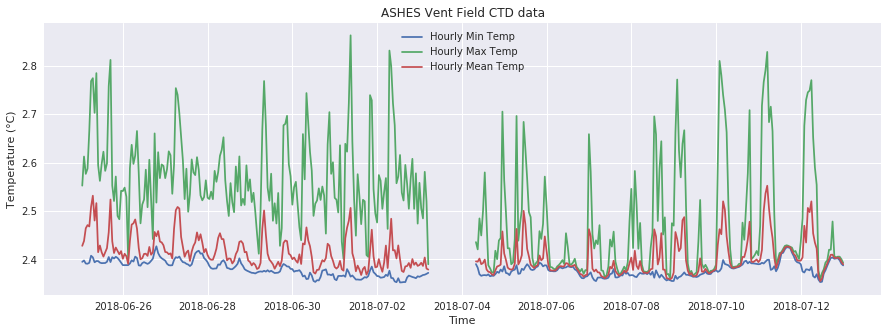

In [49]:
sns.set()
plt.figure(figsize=(15,5))
plt.plot(ctd_hourly_min["seawater_temperature"])
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("ASHES Vent Field CTD data")
plt.plot(ctd_hourly_max["seawater_temperature"])
plt.plot(ctd_hourly_mean["seawater_temperature"])
plt.legend(("Hourly Min Temp","Hourly Max Temp","Hourly Mean Temp"))

The minimum and mean temperatures remain fairly consistent with one another before and after the instrument is replaced on July 4th, but the maximum hourly temperatures show a new pattern after redeployment. Although the max temps hit similar temperatures at their peaks, the troughs between higher max values are much lower and nearly meet the mean and min temperatures. This could be due to a newer, more precise instrument reducing noise in the temperature measurements or a difference in calibration with the new instrument compared to the older one.

### Comparison between CTD temperatures and 3D Array temperatures

In [50]:
%%time
time = []
time_pd = pd.to_datetime(temp_only_ds.time.values.tolist())
for i in time_pd:
    i = np.datetime64(i).astype(datetime.datetime)
    time.append(dates.date2num(i)) 

CPU times: user 13.9 s, sys: 17 ms, total: 13.9 s
Wall time: 13.9 s


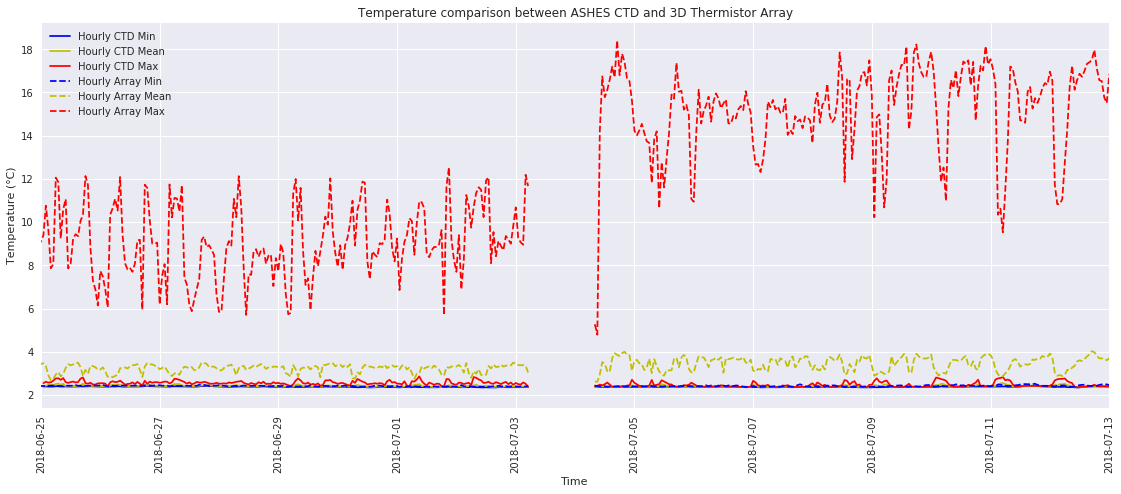

In [51]:
plt.close()
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

ax.yaxis.grid(True)
ax.xaxis.grid(True)
##Plot only the time period for which CTD data was requested
ax.set_xlim(datetime.datetime(2018, 6, 25, 0, 0),datetime.datetime(2018, 7, 13, 0, 0))

plt.tight_layout()
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.ylabel('Temperature (°C)')
plt.xlabel('Time')

##Plot CTD data as solid lines
plt.plot(ctd_hourly_min["seawater_temperature"],"b")
plt.plot(ctd_hourly_mean["seawater_temperature"],"y")
plt.plot(ctd_hourly_max["seawater_temperature"],"r")
##Plot thermistor data as dashed lines
plt.plot(min_temp_df["min_of_all_sensors"],"b--")
plt.plot(mean_temp_df["mean_of_all_sensors"],"y--")
plt.plot(max_temp_df["max_of_all_sensors"],"r--")
plt.title("Temperature comparison between ASHES CTD and 3D Thermistor Array")
plt.legend(("Hourly CTD Min","Hourly CTD Mean","Hourly CTD Max","Hourly Array Min","Hourly Array Mean","Hourly Array Max"))
plt.show()


The CTD patterns are completely obscured by the scaling required to capture the max temps, so in the next plot the y axis has been limited to between 2.25 and 4°C.

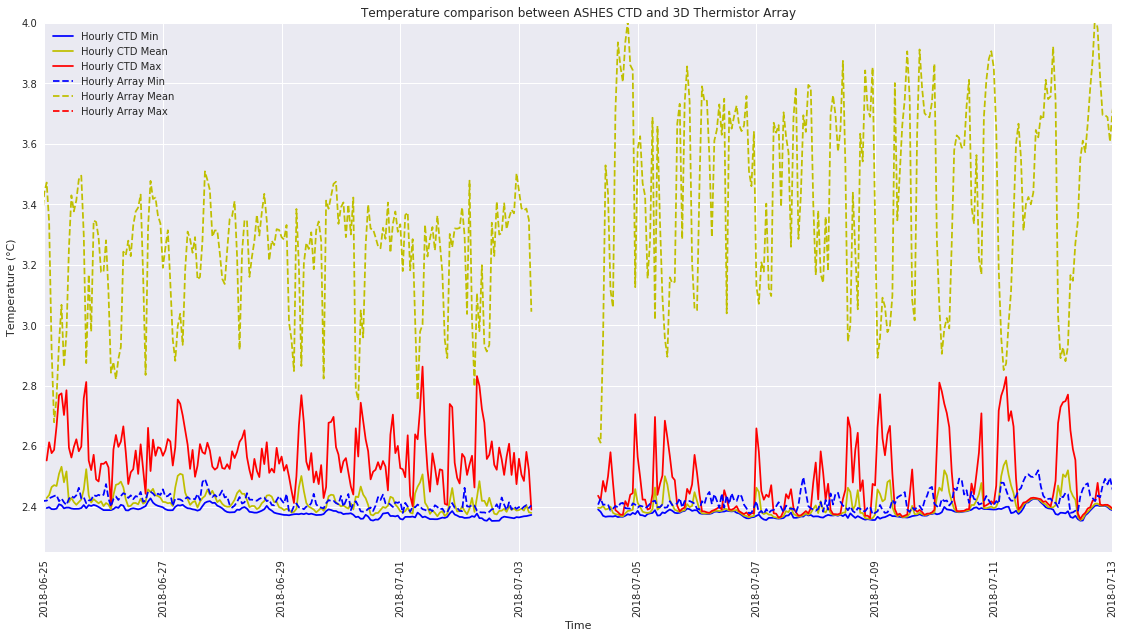

In [52]:
plt.close()
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)

ax.yaxis.grid(True)
ax.xaxis.grid(True)
##Plot only the time period for which CTD data was requested
ax.set_xlim(datetime.datetime(2018, 6, 25, 0, 0),datetime.datetime(2018, 7, 13, 0, 0))

plt.tight_layout()
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.ylabel('Temperature (°C)')
plt.xlabel('Time')

##Plot CTD data as solid lines
plt.plot(ctd_hourly_min["seawater_temperature"],"b")
plt.plot(ctd_hourly_mean["seawater_temperature"],"y")
plt.plot(ctd_hourly_max["seawater_temperature"],"r")
##Plot thermistor data as dashed lines
plt.plot(min_temp_df["min_of_all_sensors"],"b--")
plt.plot(mean_temp_df["mean_of_all_sensors"],"y--")
plt.plot(max_temp_df["max_of_all_sensors"],"r--")
plt.title("Temperature comparison between ASHES CTD and 3D Thermistor Array")
plt.legend(("Hourly CTD Min","Hourly CTD Mean","Hourly CTD Max","Hourly Array Min","Hourly Array Mean","Hourly Array Max"))
plt.ylim(2.25,4)
plt.show()

Now it is more clear that the minimum array temperature tracks the minimum CTD temperature closely while always remaining slightly warmer than the CTD. Although the mean CTD temperatures were higher than the minimum array temperatures at times, the maximum temperatures recorded by the CTD almost never reached values higher than the mean of the entire array. This is to be expected because the 3D array is purposely located significantly closer to active, warmer venting than the CTD is.

The next plot contains the same information while adding the full resolution readings from Thermistor 7 as a hexbin to see how the distribution of temperatures from that sensor compare to the range of array and CTD readings. In this case, the maximum array temperature line has been calculated with Thermistor 7 removed.

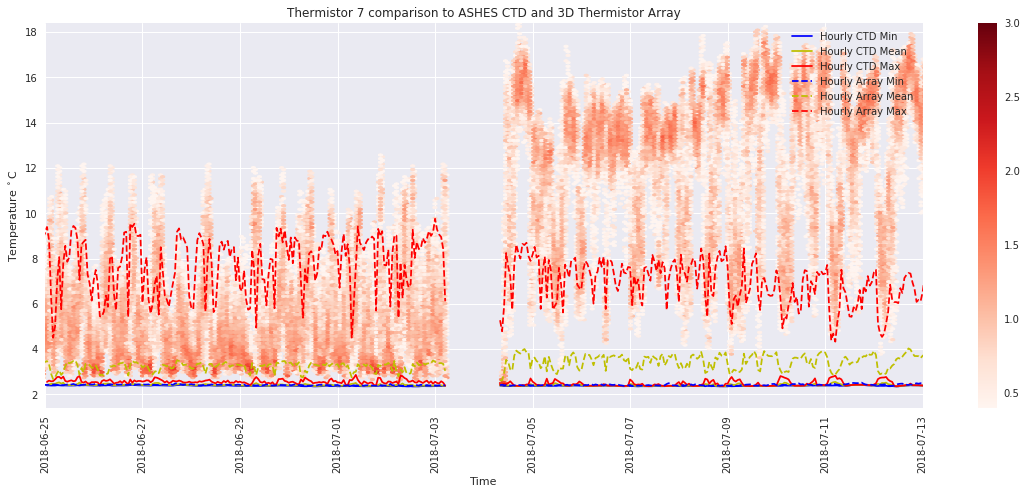

In [53]:
nonoutlier_max_temps_hourly = nonoutlier_max_temps.resample("H").max()

##Plot 3D thermistor array temperatures as a hexbin density plot
plt.close()
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

hb07 = ax.hexbin(time, temp_df["temperature07"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
fig.colorbar(hb07)
#hb01 = ax.hexbin(time, temp_df["temperature01"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
#hb02 = ax.hexbin(time, temp_df["temperature02"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
#hb03 = ax.hexbin(time, temp_df["temperature01"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
#hb04 = ax.hexbin(time, temp_df["temperature01"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
#hb05 = ax.hexbin(time, temp_df["temperature01"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
#hb06 = ax.hexbin(time, temp_df["temperature01"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
#hb07 = ax.hexbin(time, temp_df["temperature01"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
#hb08 = ax.hexbin(time, temp_df["temperature01"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
#hb09 = ax.hexbin(time, temp_df["temperature01"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
#hb10 = ax.hexbin(time, temp_df["temperature01"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
#hb11 = ax.hexbin(time, temp_df["temperature01"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
#hb12 = ax.hexbin(time, temp_df["temperature01"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
#hb13 = ax.hexbin(time, temp_df["temperature01"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
#hb14 = ax.hexbin(time, temp_df["temperature01"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
#hb15 = ax.hexbin(time, temp_df["temperature01"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
#hb16 = ax.hexbin(time, temp_df["temperature01"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
#hb17 = ax.hexbin(time, temp_df["temperature01"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
#hb18 = ax.hexbin(time, temp_df["temperature01"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
#hb19 = ax.hexbin(time, temp_df["temperature01"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
#hb20 = ax.hexbin(time, temp_df["temperature01"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
#hb21 = ax.hexbin(time, temp_df["temperature01"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
#hb22 = ax.hexbin(time, temp_df["temperature01"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
#hb22 = ax.hexbin(time, temp_df["temperature01"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
#hb24 = ax.hexbin(time, temp_df["temperature24"], bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Reds')
#fig.colorbar(hb124)
ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_xlim(datetime.datetime(2018, 6, 25, 0, 0),datetime.datetime(2018, 7, 13, 0, 0))

plt.tight_layout()
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.ylabel('Temperature $^\circ$C')
plt.xlabel('Time')
plt.plot(ctd_hourly_min["seawater_temperature"],"b")
plt.plot(ctd_hourly_mean["seawater_temperature"],"y")
plt.plot(ctd_hourly_max["seawater_temperature"],"r")
plt.plot(min_temp_df["min_of_all_sensors"],"b--")
plt.plot(mean_temp_df["mean_of_all_sensors"],"y--")
plt.plot(nonoutlier_max_temps_hourly,"r--")
plt.title("Thermistor 7 comparison to ASHES CTD and 3D Thermistor Array")
plt.legend(("Hourly CTD Min","Hourly CTD Mean","Hourly CTD Max","Hourly Array Min","Hourly Array Mean","Hourly Array Max"))
plt.show()

Here the hexbin plot allows for the visualization of the most frequent temperatures measured by Thermistor 7 in comparison to the other summary statistics. Before July 4th, the highest density of measurements are centered around the mean temperature of the entire array, and Thermistor 7 is found above the maximum temperature on those rare occasions when it is the hottest of all 24 sensors.

After July 4th, the density pattern of the thermistor shifts with more measurements recording the top temperatures of Thermistor 7's range, often 4-8°C higher than the maximum temperature of the remaining 23 thermistors. Additionally, Thermistor 7 rarely dips _below_ the maximum temperature of the non-outlier sensors.

One feature of interest to note is that the maximum temperatures (minus Thermistor 7) appear slightly lower after the July 4th redeployment. This is confirmed in calculations below that show the greatest max temperature after July 4th was 3°C hotter than the greatest max temperature after July 4th. The average max temperatures also exhibited a deficit of 0.6°C after July 4th.

In [54]:
#Find location of July 4th gap within max temp timeseries
nonoutlier_max_temps.index.get_loc('2018-07-04')

slice(545969, 551472, None)

In [55]:
#Calculate average max temp before July 4th
before_mean = nonoutlier_max_temps[:545969].mean()
before_max = nonoutlier_max_temps[:545969].max()
before_min = nonoutlier_max_temps[:545969].min()
before_mean = round(before_mean,4)

#Calculate average max temp after July 4th
after_mean = nonoutlier_max_temps[551472:].mean()
after_max = nonoutlier_max_temps[551472:].max()
after_min = nonoutlier_max_temps[551472:].min()
after_mean = round(after_mean,4)

print("Max temps (minus Thermistor 7) BEFORE July 4th ranged from %s°C to %s°C (mean of %s°C)" % (before_min,before_max,before_mean))
print()
print("Max temps (minus Thermistor 7) AFTER July 4th ranged from %s°C to %s°C (mean of %s°C)" % (after_min,after_max,after_mean))

Max temps (minus Thermistor 7) BEFORE July 4th ranged from 2.5447°C to 11.1456°C (mean of 5.8373°C)

Max temps (minus Thermistor 7) AFTER July 4th ranged from 2.6319°C to 8.5415°C (mean of 5.2164°C)


#### Further insights into Thermistor 7's unique measurements

Thermistor 7 is not experiencing a stuck value problem.

Because Thermistor 7's temperature pattern has shifted so dramatically, it is unlikely that the thermistor is suffering from a simple offset issue in its temperature readings.

And since the rest of the array's temperatures have decreased overall after Thermistor 7's data is removed from the redeployment, it's possible that Thermistor 7 is truly reading higher temperatures from a direct vent plume, bathing it in hot fluids that are somehow not reaching the rest of the array.

Again, this still requires confirmation from photos or deployment descriptions!

# Comparisons to expected tidal variation patterns in venting rates

There is another instrument within the ASHES Vent Field site that can be used to corroborate the temperature readings from the CTD and the Diffuse Vent Fluid 3D Temperature Array:

## BOTPT - Bottom Pressure and Tilt sensor
### Reference Designator RS03ASHS-MJ03B-09-BOTPTA304
The BOTPT is used primarily to measure the volcanic inflation and deflation of the seafloor to [forecast future eruptions at Axial Seamount]( https://pmel.noaa.gov/eoi/rsn/). The instrument’s [nano-resolution seafloor pressure measurements](https://oceanobservatories.org/wp-content/uploads/2015/10/1341-00070_Data_Product_SPEC_BOTPRES_OOI.pdf) can also be used to track tidal cycles, which have a known relationship with hydrothermal fluid venting rates$.^{1,3}$ Although bottom currents affected by tidal cycles certainly influence the mixing between hot vent fluids and cold seawater, a recent study found that pressure appears to be the stronger determinant of venting changes at ASHES Vent Field$.^{2}$ The proposed tidal pumping mechanism forces seawater into the seafloor as bottom pressure increases, and this in turn increases venting rates since hydrothermal fluid conduits provide the exit path of least resistance for the increased fluid volume$.^{4}$ 

It is hypothesized that the temperatures recorded by Diffuse Vent Fluid 3D Temperature Array will rise and fall cyclically in a pattern matching the tidal pressure cycles recorded by the BOTPT, and it is likely that the CTD will follow the same pattern if the instrument is located close enough to an active vent to detect the tidal venting signal. This will likely be a better way to examine the performance of individual temperature sensors. The CTD and 24 array thermistors are expected to measure very different temperatures in magnitude, but each should vary in a cyclical pattern predicted by tidal pressure within their temperature range. Flatlining sensors or extended deviations from the diurnal cycle could indicate an individually malfunctioning sensor.

**NOTE:** This 40Hz instrument produces large amounts of data quickly, so only a few days of data before and after July 4th will be examined to keep from crashing this notebook's server.

### Check instrument metadata vocabulary

In [56]:
# Instrument Information
site = 'RS03ASHS'
node = 'MJ03B'
instrument = '09-BOTPTA304'

VOCAB_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
request_url ='/'.join((VOCAB_BASE_URL,site,node,instrument))

# Retrieve vocabulary information for a given instrument
r = requests.get(request_url, auth=(USERNAME, TOKEN))
data = r.json()   ##turn JSON array into a python array

##Print info to confirm I'm retrieving data from the correct source
print("%s, %s, %s" % (data[0]['tocL1'],data[0]['tocL2'],data[0]['instrument']))

Cabled Axial Seamount, ASHES Vent Field, Bottom Pressure and Tilt


### Examining annotations for instrument

In [57]:
# Specify a reference designator
refdes = 'RS03ASHS-MJ03B-07-TMPSFA301'

# Request all annotations since the instrument has been deployed
begin = int(datetime.date(2018,1,1).strftime('%s'))*1000
end = int(datetime.datetime.now().strftime("%s")) * 1000 # current date

ANNO_API = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'
params = {
  'beginDT': begin,
  'endDT': end,
  'refdes': refdes,
}

# Send the request
r = requests.get(ANNO_API, params=params, auth=(USERNAME, TOKEN))
data = r.json()

In [58]:
##Format the annotations and timestamps

# convert timestamps
def convert_time(ms):
    if ms != None:
        return datetime.datetime.utcfromtimestamp(ms/1000)
    else:
        return None
    
# Convert info the json response to a dataframe for easier visualization
df = pd.DataFrame() # Setup empty array
for d in data:
    df = df.append({
        'annotation_id': d['id'],
        'subsite': d['subsite'],
        'node': d['node'],
        'sensor': d['sensor'],
        'stream': d['stream'],
        'method': d['method'],
        'start': convert_time(d['beginDT']),
        'stop': convert_time(d['endDT']),
        'qcFlag': d['qcFlag'],
        'annotation': d['annotation']
    }, ignore_index=True)
pd.set_option('display.max_colwidth', -1) # Show the full annotation text
df

,annotation,annotation_id,method,node,qcFlag,sensor,start,stop,stream,subsite
0,A brief violent storm caused loss of power to both the North and South cable lines and the deployed infrastructure during this time. For more information please contact help@oceanobservatories.org. (Redmine # 13109),325.0,None,None,not_operational,None,2018-01-19 03:00:01,2018-01-19 19:00:01,None,RS03ASHS


There have been no annotations this year for this instrument except for the storm which interrupted power to the entire Cabled Axial Array in January 2018.

### Request data from the BOTPT from _before_ July 4th redeployment

In [59]:
# Instrument Information
site = 'RS03ASHS'
node = 'MJ03B'
instrument = '09-BOTPTA304'
method = 'streamed'
stream = 'botpt_nano_sample'
#stream = 'botpt_nano_sample_15s'

# API base url
SENSOR_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

# Create the full request URL
data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))

# All of the following are optional
params = {
  #'beginDT':'2018-06-01T01:01:01.000Z',  ##same timeframe as temperature sensor and CTD
  'beginDT':'2018-06-30T01:00:00.000Z',
  'endDT':'2018-07-03T01:01:01.000Z',
  'format':'application/netcdf',
  'include_provenance':'true',
  'include_annotations':'true'
}

In [ ]:
#r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
#botpt_data = r.json()
#print(botpt_data['allURLs'][0])

In [18]:
botpt_url = "https://opendap.oceanobservatories.org/thredds/catalog/ooi/alanna.g.durkin@gmail.com/20180810T023018-RS03ASHS-MJ03B-09-BOTPTA304-streamed-botpt_nano_sample/catalog.html"

In [19]:
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
botpt_datasets = requests.get(botpt_url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', botpt_datasets)
x = re.findall(r'(ooi/.*?.nc)', botpt_datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
botpt_datasets = [os.path.join(tds_url, i) for i in x]
botpt_datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/alanna.g.durkin@gmail.com/20180810T023018-RS03ASHS-MJ03B-09-BOTPTA304-streamed-botpt_nano_sample/deployment0003_RS03ASHS-MJ03B-09-BOTPTA304-streamed-botpt_nano_sample_20180630T005959.900000-20180703T010101.100000.nc']

In [21]:
## Clear unnecessary variables in a vain attempt to have enough memory for THREE DAYS of BOTPT pressures
del df, dfsorted, ds, temp_only_ds, temp_df, bad_temp_ds, bad_temp_only_ds, bad_temp_df, maxIDs, max_streaks, max_sensors, streak_data, bad_max_streaks, bad_max_sensors, bad_streak_data, diff, dict3D, ctd_ds, ctd_select_ds, ctd_df
#del ds, temp_only_ds, temp_df, ctd_ds, ctd_select_ds, ctd_df


In [22]:
# Load the data files
botpt_ds = xr.open_mfdataset(botpt_datasets)

In [23]:
# By default, OOI datasets use the 'obs' variable as the index, but time is more convenient
botpt_ds = botpt_ds.swap_dims({'obs': 'time'}) 

# Sort the data
botpt_ds = botpt_ds.sortby('time'); 

# Optional, this is used to optimize data processing
botpt_ds = botpt_ds.chunk({'time': 100}) 

botpt_ds

<xarray.Dataset>
Dimensions:                      (time: 5185091)
Coordinates:
    obs                          (time) int32 dask.array<shape=(5185091,), chunksize=(100,)>
  * time                         (time) datetime64[ns] 2018-06-30T00:59:59.900000256 ...
    lat                          (time) float64 dask.array<shape=(5185091,), chunksize=(100,)>
    lon                          (time) float64 dask.array<shape=(5185091,), chunksize=(100,)>
Data variables:
    deployment                   (time) int32 dask.array<shape=(5185091,), chunksize=(100,)>
    id                           (time) |S64 dask.array<shape=(5185091,), chunksize=(100,)>
    bottom_pressure              (time) float32 dask.array<shape=(5185091,), chunksize=(100,)>
    date_time_string             (time) object dask.array<shape=(5185091,), chunksize=(100,)>
    driver_timestamp             (time) datetime64[ns] dask.array<shape=(5185091,), chunksize=(100,)>
    ingestion_timestamp          (time) datetime64[ns] da

In [24]:
#Drop the columns in the dataset that won't be used in this analysis
all_botpt_data_vars = list(botpt_ds.data_vars)

dropped_vars = []
for i in all_botpt_data_vars:
    if i == "bottom_pressure":
        pass
    else:
        dropped_vars.append(i)
        
#Drop extraneous variables from the dataset
botpt_ds = botpt_ds.drop(dropped_vars)
botpt_ds

<xarray.Dataset>
Dimensions:          (time: 5185091)
Coordinates:
    obs              (time) int32 dask.array<shape=(5185091,), chunksize=(100,)>
  * time             (time) datetime64[ns] 2018-06-30T00:59:59.900000256 ...
    lat              (time) float64 dask.array<shape=(5185091,), chunksize=(100,)>
    lon              (time) float64 dask.array<shape=(5185091,), chunksize=(100,)>
Data variables:
    bottom_pressure  (time) float32 dask.array<shape=(5185091,), chunksize=(100,)>
Attributes:
    _NCProperties:                      version=1|netcdflibversion=4.4.1.1|hd...
    node:                               MJ03B
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  streamed
    stream:                             botpt_nano_sample
    featureType:                        point
    creator_email:                      
    publisher_name:     

In [25]:
#Convert the dataset to a pandas dataframe
botpt_df = botpt_ds.to_dataframe()

In [26]:
#Resample to hourly pressure measures
botpt_before_hourly_mean = botpt_df.resample("H").mean()

Text(0,0.5,'Seafloor Pressure (psia)')

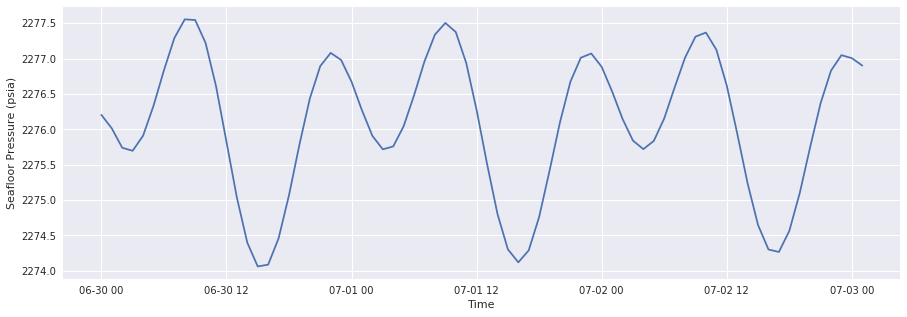

In [68]:
sns.set()
plt.figure(figsize=(15,5))
plt.plot(botpt_before_hourly_mean["bottom_pressure"])
plt.xlabel("Time")
plt.ylabel("Seafloor Pressure (psia)")

The following code for plotting two variables with different y-axes came from a [matplotlib gallery example](https://matplotlib.org/gallery/api/two_scales.html).

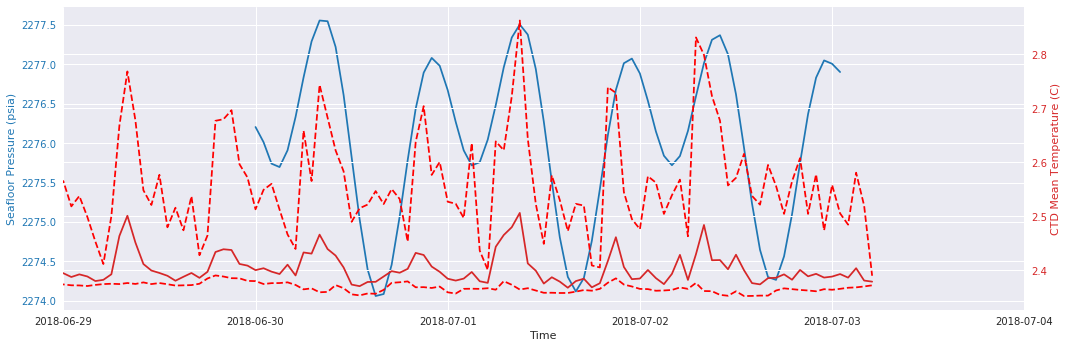

In [70]:
##Plot CTD temperature fluctuations in comparison to pressure changes
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.set_xlabel('Time')
ax1.set_ylabel('Seafloor Pressure (psia)', color="tab:blue")
ax1.plot(botpt_before_hourly_mean["bottom_pressure"], color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.set_xlim([datetime.date(2018, 6, 29), datetime.date(2018, 7, 4)])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('CTD Mean Temperature (°C)', color="tab:red")  # we already handled the x-label with ax1
ax2.plot(ctd_hourly_mean["seawater_temperature"], color="tab:red")
ax2.plot(ctd_hourly_min["seawater_temperature"],"r--")
ax2.plot(ctd_hourly_max["seawater_temperature"],"r--")
ax2.tick_params(axis='y', labelcolor="tab:red")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Over the three days of manageable BOTPT data, the CTD is showing the predicted relationship between tidal pressure and temperature. Even though this sensor is not purposely located close to an active vent, it is still able to record the rising temperature of bottom seawater caused by increased venting rates. Although a longer time period would need to be analyzed to be certain, both the maximum and minimum hourly CTD temperatures support this relationship visibly.

### Compare 3D Array temperatures to BOTPT cycles

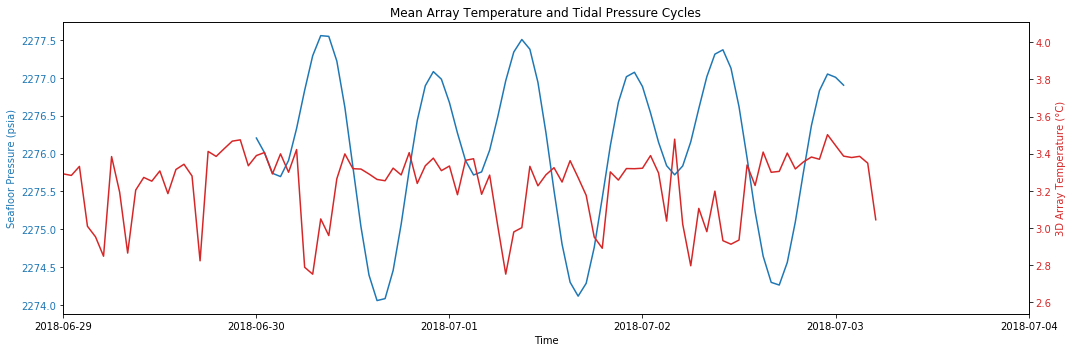

In [35]:
##Plot CTD temperature fluctuations in comparison to pressure changes
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.set_xlabel('Time')
ax1.set_ylabel('Seafloor Pressure (psia)', color="tab:blue")
ax1.plot(botpt_before_hourly_mean["bottom_pressure"], color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.set_xlim([datetime.date(2018, 6, 29), datetime.date(2018, 7, 4)])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('3D Array Temperature (°C)', color="tab:red")  # we already handled the x-label with ax1
ax2.plot(mean_temp_df["mean_of_all_sensors"], color="tab:red")
ax2.tick_params(axis='y', labelcolor="tab:red")
ax2.set_title("Mean Array Temperature and Tidal Pressure Cycles")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

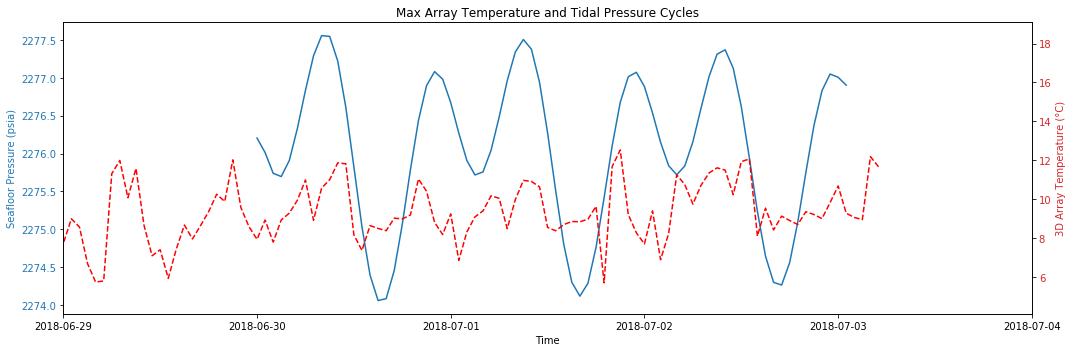

In [33]:
##Plot CTD temperature fluctuations in comparison to pressure changes
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.set_xlabel('Time')
ax1.set_ylabel('Seafloor Pressure (psia)', color="tab:blue")
ax1.plot(botpt_before_hourly_mean["bottom_pressure"], color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.set_xlim([datetime.date(2018, 6, 29), datetime.date(2018, 7, 4)])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('3D Array Temperature (°C)', color="tab:red")  # we already handled the x-label with ax1
ax2.plot(max_temp_df["max_of_all_sensors"], "r--")
ax2.tick_params(axis='y', labelcolor="tab:red")
ax2.set_title("Max Array Temperature and Tidal Pressure Cycles")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Although it is difficult to discern the strength of the tidal pressure relationship from just three days of data, these plots unexpectedly show that the _maximum_ temperature recorded by the array tracks tidal cycles better than the _mean_ temperatures of all 24 thermistors. More days of data need to be analyzed, and this analysis would benefit from an attempt to de-trend the temperature data from the diurnal tidal pressure cycles. It may also be worth investigating how bottom currents change with the tides and potentially influence temperature readings by redirecting hydrothermal fluid, but this is still unlikely to explain why the array's maximum temperature may align more closely with tidal cycles than its mean temperature.

### Request data from the BOTPT from _after_ July 4th redeployment

In [71]:
# Instrument Information
site = 'RS03ASHS'
node = 'MJ03B'
instrument = '09-BOTPTA304'
method = 'streamed'
stream = 'botpt_nano_sample'
#stream = 'botpt_nano_sample_15s'

# API base url
SENSOR_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

# Create the full request URL
data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))

# All of the following are optional
params = {
  'beginDT':'2018-07-05T01:00:00.000Z',
  'endDT':'2018-07-08T01:01:01.000Z',
  'format':'application/netcdf',
  'include_provenance':'true',
  'include_annotations':'true'
}

In [72]:
#r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
#botpt_data = r.json()
#print(botpt_data['allURLs'][0])

https://opendap.oceanobservatories.org/thredds/catalog/ooi/alanna.g.durkin@gmail.com/20180810T034138-RS03ASHS-MJ03B-09-BOTPTA304-streamed-botpt_nano_sample/catalog.html


In [31]:
botpt_url = "https://opendap.oceanobservatories.org/thredds/catalog/ooi/alanna.g.durkin@gmail.com/20180810T034138-RS03ASHS-MJ03B-09-BOTPTA304-streamed-botpt_nano_sample/catalog.html"

In [32]:
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
botpt_datasets = requests.get(botpt_url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', botpt_datasets)
x = re.findall(r'(ooi/.*?.nc)', botpt_datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
botpt_datasets = [os.path.join(tds_url, i) for i in x]
botpt_datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/alanna.g.durkin@gmail.com/20180810T034138-RS03ASHS-MJ03B-09-BOTPTA304-streamed-botpt_nano_sample/deployment0003_RS03ASHS-MJ03B-09-BOTPTA304-streamed-botpt_nano_sample_20180705T005959.900000-20180708T010101.100000.nc']

In [33]:
# Load the data files
del botpt_ds
botpt_ds = xr.open_mfdataset(botpt_datasets)

In [34]:
# By default, OOI datasets use the 'obs' variable as the index, but time is more convenient
botpt_ds = botpt_ds.swap_dims({'obs': 'time'}) 

# Sort the data
botpt_ds = botpt_ds.sortby('time'); 

# Optional, this is used to optimize data processing
botpt_ds = botpt_ds.chunk({'time': 100}) 

botpt_ds

<xarray.Dataset>
Dimensions:                      (time: 5144495)
Coordinates:
    obs                          (time) int32 dask.array<shape=(5144495,), chunksize=(100,)>
  * time                         (time) datetime64[ns] 2018-07-05T00:59:59.900000256 ...
    lat                          (time) float64 dask.array<shape=(5144495,), chunksize=(100,)>
    lon                          (time) float64 dask.array<shape=(5144495,), chunksize=(100,)>
Data variables:
    deployment                   (time) int32 dask.array<shape=(5144495,), chunksize=(100,)>
    id                           (time) |S64 dask.array<shape=(5144495,), chunksize=(100,)>
    bottom_pressure              (time) float32 dask.array<shape=(5144495,), chunksize=(100,)>
    date_time_string             (time) object dask.array<shape=(5144495,), chunksize=(100,)>
    driver_timestamp             (time) datetime64[ns] dask.array<shape=(5144495,), chunksize=(100,)>
    ingestion_timestamp          (time) datetime64[ns] da

In [35]:
#Drop extraneous variables from the dataset
botpt_ds = botpt_ds.drop(dropped_vars)
botpt_ds

<xarray.Dataset>
Dimensions:          (time: 5144495)
Coordinates:
    obs              (time) int32 dask.array<shape=(5144495,), chunksize=(100,)>
  * time             (time) datetime64[ns] 2018-07-05T00:59:59.900000256 ...
    lat              (time) float64 dask.array<shape=(5144495,), chunksize=(100,)>
    lon              (time) float64 dask.array<shape=(5144495,), chunksize=(100,)>
Data variables:
    bottom_pressure  (time) float32 dask.array<shape=(5144495,), chunksize=(100,)>
Attributes:
    _NCProperties:                      version=1|netcdflibversion=4.4.1.1|hd...
    node:                               MJ03B
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  streamed
    stream:                             botpt_nano_sample
    featureType:                        point
    creator_email:                      
    publisher_name:     

In [ ]:
#Convert the dataset to a pandas dataframe
botpt_df = botpt_ds.to_dataframe()

In [ ]:
#Resample to hourly pressure measures
botpt_after_hourly_mean = botpt_df.resample("H").mean()

In [ ]:
sns.set()
plt.figure(figsize=(15,5))
plt.plot(botpt_after_hourly_mean["bottom_pressure"])
plt.xlabel("Time")
plt.ylabel("Seafloor Pressure (psia)")

In [ ]:
##Plot CTD temperature fluctuations in comparison to pressure changes
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.set_xlabel('Time')
ax1.set_ylabel('Seafloor Pressure (psia)', color="tab:blue")
ax1.plot(botpt_after_hourly_mean["bottom_pressure"], color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.set_xlim([datetime.date(2018, 7, 4), datetime.date(2018, 7, 9)])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('CTD Mean Temperature (°C)', color="tab:red")  # we already handled the x-label with ax1
ax2.plot(ctd_hourly_mean["seawater_temperature"], color="tab:red")
ax2.plot(ctd_hourly_min["seawater_temperature"],"r--")
ax2.plot(ctd_hourly_max["seawater_temperature"],"r--")
ax2.tick_params(axis='y', labelcolor="tab:red")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Compare 3D Array temperatures to BOTPT cycles

In [ ]:
##Plot CTD temperature fluctuations in comparison to pressure changes
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.set_xlabel('Time')
ax1.set_ylabel('Seafloor Pressure (psia)', color="tab:blue")
ax1.plot(botpt_after_hourly_mean["bottom_pressure"], color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.set_xlim([datetime.date(2018, 6, 29), datetime.date(2018, 7, 4)])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('3D Array Temperature (°C)', color="tab:red")  # we already handled the x-label with ax1
ax2.plot(mean_temp_df["mean_of_all_sensors"], color="tab:red")
ax2.tick_params(axis='y', labelcolor="tab:red")
ax2.set_title("Mean Array Temperature and Tidal Pressure Cycles")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
##Plot CTD temperature fluctuations in comparison to pressure changes
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.set_xlabel('Time')
ax1.set_ylabel('Seafloor Pressure (psia)', color="tab:blue")
ax1.plot(botpt_after_hourly_mean["bottom_pressure"], color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.set_xlim([datetime.date(2018, 6, 29), datetime.date(2018, 7, 4)])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('3D Array Temperature (°C)', color="tab:red")  # we already handled the x-label with ax1
ax2.plot(max_temp_df["max_of_all_sensors"], "r--")
ax2.tick_params(axis='y', labelcolor="tab:red")
ax2.set_title("Max Array Temperature and Tidal Pressure Cycles")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Suggested Next Steps:
1. Perform the same analyses for longer time periods for all instruments.
2. Investigate new CTD data after July 4th to see why it contains less noise than previous temperature measurements.
3. Find precise location data for the 3D array to help determine whether Thermistor 7 is measuring a real hot fluid plume or recording erroneous data.
4. Investigate the Quality Control measures recorded for each thermistor within the 3D array. Is Thermistor 7 failing any QC tests? What tests did Thermistors 2 and 6 fail when they were previously marked as recording incorrectly high temperatures?
5. Take a more precise look at the relationship between tidal pressure and temperature by modeling the BOTPT data with a sinusoidal function from which a predictive temperature model could be created to observe the difference between predicted and measured temperature (detrended from tidal cycles).

## References

1. 	Kent AJR, Baker JA, Wiedenbeck M. Insights into tide-related variability at seafloor hydrothermal vents from time-series temperature measurements. _Earth Planet Sci Lett._ 2002;202(3-4):693-707. doi:10.1016/S0012-821X(02)00801-4.
2. 	Scheirer DS, Shank TM, Fornari DJ. Temperature variations at diffuse and focused flow hydrothermal vent sites along the northern East Pacific Rise. _Geochemistry, Geophys Geosystems._ 2006;7(3). doi:10.1029/2005GC001094.
3. 	Mittelstaedt E, Fornari DJ, Crone TJ, Kinsey J, Kelley D, Elend M. Diffuse venting at the ASHES hydrothermal field: Heat flux and tidally modulated flow variability derived from in situ time-series measurements. _Geochemistry Geophys Geosystems._ 2016;17:1435-1453. doi:10.1080/01621459.1988.10478717.
4. 	Pruis MJ, Johnson HP. Tapping into the sub-seafloor: Examining diffuse flow and temperature from an active seamount on the Juan de Fuca Ridge. _Earth Planet Sci Lett._ 2004;217(3-4):379-388. doi:10.1016/S0012-821X(03)00607-1.
